In [ ]:
# Folders project structure
#dataset is the root folder

# dataset |----> edf       |----> epilesy #edf files
#                           |----> no_epilesy #edf files
#
#         |----> extraction |----> epilesy #edf to csv
#                           |----> no_epilesy #edf to csv
#
#         |----> division   |----> epilesy #csv standardize
#                           |----> no_epilesy #csv standardize
#
#         |----> info
#        
#         |----> prod


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
!pip install mne
!pip install -q pyyaml h5py 
!pip install -U keras-tuner
!pip install pyedflib opencv-python
#!pip install pypng

     |████████████████████████████████| 7.0MB 2.9MB/s 
     |████████████████████████████████| 71kB 2.6MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=6bbf57cec360821279620b17d85d609b9f8d8a107c11509f55af87aa4f4fe474
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=53f80a71152b2e717726ca08f20e8009a45b87397908d17a7bf762728334a851
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables
     |████████████████████████████████| 1.3MB 4.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyedflib: filename=pyEDFlib-0.1.22-cp37-cp37m-linux_x86_64.whl size=1520516 sha256=266882188a6fa9a11a5

In [ ]:
projet_path = "/content/drive/MyDrive/dataset/"

In [ ]:
cd {projet_path}

/content/drive/MyDrive/dataset


In [ ]:
import mne
import os.path as path
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
import datetime
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from tensorflow.keras.layers.experimental import preprocessing
import scipy
from scipy.signal import filtfilt,butter
import pandas as pd
import seaborn as sns
import uuid
import shutil
import random
import librosa as lib
import librosa.display as lib_disp

from os import listdir as listd
from os.path import isfile,join
import glob
import pprint
import re
import pyedflib
from mne.preprocessing import ICA
#from mne.preprocessing import create
from PIL import Image
import cv2
pd.set_option('display.max_colwidth', None)

In [ ]:
%load_ext tensorboard
!rm -rf {projet_path+"tensorboard_logs"}

In [ ]:
#tf.executing_eagerly()

In [ ]:
base = projet_path

#Functions

In [ ]:
def get_label(file_path):
  return tf.strings.split(file_path,os.path.sep)[-2]

def get_sizes(csv_names):
  data = pd.DataFrame([],columns=["length","width","columns"])
  for file_path in csv_names:
    raw = pd.read_csv(file_path)
    data = data.append({"length":raw.shape[0],"width":raw.shape[1],"columns":list(raw.columns)}, ignore_index=True)
    
  return data

def make_df_info(csv_names):
  size = get_sizes(csv_names)
  data_shape = pd.DataFrame({"path":csv_names})
  data_shape = pd.concat([size,data_shape],axis=1)
  data_shape["label"] = data_shape.path.map(lambda x : x.split("/")[-2])
  return data_shape

In [ ]:
def csv_path_to_edf(path):
  return path.replace("extraction","edfu").replace("csv","edf")

def plot_raw(path,file_type="csv"):
  if file_type=="csv":
    path = csv_path_to_edf(path)

  raw = mne.io.read_raw_edf(path) 
  raw.plot()
    

In [ ]:
def str_index_to_list(index):
  return index.replace("'","").replace("[","").replace("]","").split(",")

def replace_diff(x):
  return x.replace("-REF","").replace("-LE","").replace("EEG","").replace(" ","")

In [ ]:
# this function divide csv files with more than 40000 rows
def divide_csv(df,threshold,p,column_names,continue_at=0):
  div=pd.DataFrame([],columns=column_names)

  for j, path in enumerate(df["path"]):
    if j >= continue_at:
      temp = pd.read_csv(path)

      temp.columns = replace_diff(",".join(list(temp.columns))).split(",")
      current_col = temp.columns
      to_drop = [ col for col in current_col if not col in column_names]
    
      temp.drop(to_drop,axis=1,inplace=True)
      current_col = temp.columns
      #print("1=>",div.shape)
      
      div = pd.concat([div,temp])
      current_col = div.columns
        
      if len(current_col)!=len(column_names):
        print("anomalie : "+str(len(current_col))+" colonnes")
        print(path)
        return

      nb_div = div.shape[0]//threshold
      label = path.split(os.path.sep)[-2]
      file_name = path.split(os.path.sep)[-1][:-4] 
      for i in range(1,nb_div+1):
        new_path = p+os.path.sep+label+os.path.sep+file_name+"_"+str(i)+".csv"
        if not os.path.isfile(new_path):
          div[:threshold].to_csv(new_path,index=False)
        div=div[(threshold):]
        #print(div.shape)
      print(str(j))
      if j+1==len(df["path"]) and div.shape[0]<threshold and not div.empty:
        rest = threshold - div.shape[0]
        dd = pd.DataFrame(np.zeros((rest,len(column_names))),columns=column_names)
        div = pd.concat([div,dd])
        new_path = p+os.path.sep+label+os.path.sep+str(uuid.uuid1())+".csv"
        if div.shape[0]!=threshold:
          print("anomalie : "+str(div.shape[0])+" lignes")
          print(path)
          return
        div.to_csv(new_path,index=False)
        print("reste",div.shape)
          

In [ ]:
# this function concatenate csv files with least than 40000 rows
def merge_csv(df,threshold,p,column_names):
  to_save = pd.DataFrame([],columns=column_names)
  end = False
  
  for i, path in enumerate(df["path"]):
    label = path.split(os.path.sep)[-2]
    if to_save.shape[0] < threshold:
      temp = pd.read_csv(path)
      temp.columns = replace_diff(",".join(list(temp.columns))).split(",")
      current_col = temp.columns
      to_drop = [ col for col in current_col if not col in column_names]
      temp.drop(to_drop,axis=1,inplace=True)
      current_col = temp.columns

      to_save = pd.concat([to_save,temp])

      if len(current_col)!=len(column_names):
        print("anomalie colonnes : "+str(len(current_col))+" colonnes")
        print(path)
        return

      if to_save.shape[0]>=threshold:
        new_path = p+os.path.sep+label+os.path.sep+"_i"+str(uuid.uuid1())+".csv"
        if to_save.shape[0]<threshold:
            print("anomalie lignes t1 : "+str(to_save.shape[0])+" lignes")
            print(path)
            return
        to_save[:threshold].to_csv(new_path)
        to_save = to_save[threshold:]
        
    print(str(i))
    
    if (len(df["path"])==i+1 and to_save.shape[0] < threshold):
      rest = threshold - to_save.shape[0]
      dd = pd.DataFrame(np.zeros((rest,len(column_names))),columns=column_names)
      to_save = pd.concat([to_save,dd])
      new_path = p+os.path.sep+label+os.path.sep+"_i"+str(uuid.uuid1())+".csv"
      if to_save.shape[0]!=threshold:
          print("anomalie lignes t2: "+str(to_save.shape[0])+" lignes")
          print(path)
          return
      print("fin : "+ str(to_save.shape[0]))
      to_save.to_csv(new_path)
      return

In [ ]:
# this function apply pass band filter on a signal
def passBandFilter(signal):
  fs = 40000.0
  lowcut = 0.1
  highcut = 50.0
  nyq = fs * 0.5
  low = lowcut  / nyq
  high = highcut  / nyq

  b, a = butter(2,[low,high],"bandpass",analog=False)
  y=filtfilt(b,a,signal,axis=0)
  return y

def plot_signal_spect(data_column,col_name):
  filteredSig=passBandFilter(data_column)
  spect = tf.signal.stft(data_column, frame_length=255, frame_step=128)
  #spect = lib.feature.mfcc(np.array(filteredSig),n_mfcc=20)
  spect = tf.abs(tf.dtypes.cast(spect, tf.float64))
  length = len(data_column)

  plt.figure(figsize=(12,8))
  timescale = np.arange(length) 

  plt.subplot(3,1,1,xlim=[0, length],title="Waveform - "+col_name,xticklabels=[] )
  plt.plot(timescale,data_column)

  plt.subplot(3,1,2,xlim=[0, length],title="Waveform filtered - "+col_name,xticklabels=[] )
  plt.plot(timescale,filteredSig)

  plt.subplot(3,1,3,title="Spectrogram - "+col_name )
  #lib_disp.specshow(lib.amplitude_to_db(spect.numpy()))
  lib_disp.specshow(lib.amplitude_to_db(spect.numpy().T))
  plt.show()

def plot_signals_spects(data_frame,plot_all=False):
  for col in data_frame.columns:
    plot_signal_spect(list(data_frame[col]),col)
    if not plot_all:
      break

In [ ]:
# All these functions in this section are used to apply all preprocing and normalization for the deployment
def get_data_label2(file_names):
  scaler = MinMaxScaler()
  encoder = LabelEncoder()
  data = []
  labels = []
  for i,path in enumerate(file_names):
    label = tf.compat.as_str(
      get_label(path).numpy(), encoding='utf-8')
    raw = pd.read_csv(path)
    nd=[]
    print(i)
    if 'Unnamed: 0' in list(raw.columns):
      raw.drop("Unnamed: 0",axis=1,inplace=True,errors="ignore")
      raw.to_csv(path,index=False)

    for col in raw.columns:
      
      #filteredSig=passBandFilter(raw[col])
      #spect = lib.feature.mfcc(np.array(filteredSig),n_mfcc=20)
      spect = tf.signal.stft(list(raw[col]), frame_length=255, frame_step=128,)
      spect = tf.abs(tf.dtypes.cast(spect, tf.float64))
      nd.append(lib.amplitude_to_db(spect.numpy()))
      
    nd=np.transpose(nd, (1, 2, 0))
    raw = tf.convert_to_tensor(nd/nd.max())
    data.append(raw)
    labels.append(label)
  labels=np.array(encoder.fit_transform(labels))# 
  print(labels)

  return (data,labels)

def divide_file(data_file,threshold,p,nb_cols=19):
  cols = [str(i) for i in range((nb_cols))]
  div=pd.DataFrame([],columns=cols)

  for j, path in enumerate(data_file["path"]):
    temp = pd.read_csv(path)
      
    n_cols = len((temp.columns))
    if n_cols > nb_cols:
      to_drop = temp.columns[nb_cols:]
      temp.drop(to_drop,axis=1,inplace=True)
      
    else :
      rest = nb_cols - n_cols
      rembourrage = np.zeros((threshold,1))
      for i in range(rest):
        temp[i]=rembourrage
        
    if len(temp.columns)!=nb_cols:
      print("anomalie : "+str(temp.columns)+" colonnes")
      print(path)
      return
    temp.columns = cols#div.columns
    div = pd.concat([div,temp])

    if div.shape[0]>threshold:
      nb_div = div.shape[0]//threshold
      file_name = path.split(os.path.sep)[-1][:-4] 
      for i in range(1,nb_div+1):
        new_path = p+file_name+"_"+str(i)+".csv"
        if not os.path.isfile(new_path):
          div[:threshold].to_csv(new_path,index=False)
        div=div[(threshold):]
        #print(div.shape)
    print(str(j))
    if j+1==len(data_file["path"]) and div.shape[0]<threshold and not div.empty:
      rest = threshold - div.shape[0]
      dd = pd.DataFrame(np.zeros((rest,len(div.columns))),columns=div.columns)
      div = pd.concat([div,dd])
      new_path = p+str(uuid.uuid1())+".csv"
      if div.shape[0]!=threshold:
        print("anomalie : "+str(div.shape[0])+" lignes")
        print(path)
        return
      div.to_csv(new_path,index=False)
      print("reste",div.shape)

def preprocessing_edf(root,edf_files=[],id=str(uuid.uuid1())):
  data_file = pd.DataFrame([],columns=["length","width","path","columns"])

  dir = root+"prod"+os.path.sep+id+os.path.sep
  tf.io.gfile.makedirs(dir)
  for path in edf_files:
    file_name = path.split(os.path.sep)[-1][:-4]
    new_path = dir+os.path.sep+file_name+".csv"
    
    if not os.path.isfile(new_path):
      raw = mne.io.read_raw_edf(path)
      df = pd.DataFrame(raw.to_data_frame(),columns=raw.ch_names)
      data_file = data_file.append({"length":df.shape[0],"width":df.shape[1],"path":new_path,"columns":list(df.columns)}, ignore_index=True)
      df.to_csv(new_path,index=False)
  
  #suppresion des edf

  threshold=40000
  # division
  divide_file(data_file,threshold,dir)

  #suppression des csv
  for path in data_file["path"]:
    os.remove(path)

  print(dir[:-1])
  csv_names = tf.io.gfile.glob(str(dir) + '*.csv')

  return csv_names
  

def prediction(data_set):
  modele = models.load_model(projet_path+'my_model.h5')
  preds = modele.predict_classes(data_set)
  score = {"epilepsy": 0,"no_epilepsy": 0}
  for pred in preds:
    if pred == 0:
      score["epilepsy"]+=1
    else:
      score["no_epilepsy"]+=1
  print("predictions :", preds)
  print("score :", score)
  return  max(score, key=lambda k: score[k])



In [ ]:
def plot_history(history):
  print(history[0].history.keys())
  # summarize history for accuracy
  plt.plot(history[0].history['accuracy'])
  plt.plot(history[0].history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history[0].history['loss'])
  plt.plot(history[0].history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
#Function to list a file name of directory in a list
def list_files_folder(folder_path,output=False):
    pp = pprint.PrettyPrinter()
    file_list = []

    for filename in listd(folder_path):
        if isfile(join(folder_path,filename)):
            file_list.append(filename)

    file_list.sort()

    if output==True:
        print(str(len(file_list)) + ' files found')
        pp.pprint(filename)

    return file_list


# Function to return df which content essential egg informations
def df_info(data,edfDic,typeOf,basePath):
    nomList = ['name','nchan','highpass','lowpass','sfreq','link']
    df = pd.DataFrame(columns=nomList)

    for i in range(1,len(data)):
    #for i in range(1,3):
        edf = path.join(basePath,typeOf,edfDic[typeOf][i])
        raw = mne.io.read_raw_edf(edf)
        dic={'name':edfDic[typeOf][i].split('.')[0],'nchan':raw.info['nchan'],'highpass':raw.info['highpass'],'lowpass':raw.info['lowpass'],'sfreq':raw.info['sfreq'],'link':edf}
        df = df.append(dic,ignore_index=True)

    return df

# list all no EEG signal in a raw
def list_no_EEG(raw):
    liste = []
    for f in raw.info['ch_names']:
        if 'EEG' not in f:
            liste.append(f)
    return liste

# remove bad channel
def remove_bad_channel(raw,info=False):
    real_bad_list = []
    del_chan = 0
    #a list of no common chanel
    liste = ['20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30',
       '31', '32', 'A1', 'A2', 'BURSTS', 'C3P', 'C4P', 'DC1-DC', 'DC2-DC',
       'DC3-DC', 'DC4-DC', 'DC5-DC', 'DC6-DC', 'DC7-DC', 'DC8-DC',
       'EDFANNOTATIONS', 'EKG', 'EKG1', 'EMG', 'IBI', 'LOC', 'LUC', 'OZ',
       'PG1', 'PG2', 'PHOTIC', 'RLC', 'ROC', 'SP1', 'SP2',
       'SUPPR', 'T1', 'T2']
    
    for i in range(len(raw.info['ch_names'])):
        for j in liste:
            if j in raw.info['ch_names'][i]:
                real_bad_list.append(raw.info['ch_names'][i])
                del_chan = del_chan+1
                if info:
                    print('I will delete ',raw.info['ch_names'][i],' channel')
    raw.drop_channels(real_bad_list)
    print(str(del_chan),' Channels deleted')

def replaceChar(string,replace,by,pos):
    final=""
    position = False
    for i in range(len(string)):
        if string[i]==replace and pos == i:
            position = True
    if position:
        for i in range(len(string)):
            if string[i]==replace and pos == i:
                final = final+by
            else:
                final = final+string[i]
        return final
    return string

def replace_diff(x):
  string = x.replace("-REF","").replace("-LE","").replace("EEG","").replace(" ","").replace("Z","z")
  return replaceChar(string, 'P', 'p', 1)



def change_channel_name(raw,info=False):
    raw_to=raw
    for i in range(len(raw_to.info['ch_names'])):
        raw.rename_channels({raw_to.info['ch_names'][i]:replace_diff(raw_to.info['ch_names'][i])})
    return raw_to


def transform_physical_eeg_df(data_file, selected_channels=[]):

    try:
        # use the reader to get an EdfReader file
        f = pyedflib.EdfReader(data_file)

        # get the names of the signals
        channel_names = f.getSignalLabels()
        # get the sampling frequencies of each signal
        channel_freq = f.getSampleFrequencies()
        
        # get a list of the EEG channels
        if len(selected_channels) == 0:
            selected_channels = channel_names

        # make an empty file of 0's
        sigbufs = np.zeros((f.getNSamples()[0],len(selected_channels)))
        # for each of the channels in the selected channels
        for i, channel in enumerate(selected_channels):
            try:
              # add the channel data into the array
              sigbufs[:, i] = f.readSignal(channel_names.index(channel))
            
            except:
              ValueError
              # This happens if the sampling rate of that channel is 
              # different to the others.
              # For simplicity, in this case we just make it na.
              sigbufs[:, i] = np.nan


        # turn to a pandas df and save a little space
        df = pd.DataFrame(sigbufs, columns = selected_channels)#.astype('float32')

        # get equally increasing numbers upto the length of the data depending
        # on the length of the data divided by the sampling frequency
        index_increase = np.linspace(0,
                                      len(df)/channel_freq[0],
                                      len(df), endpoint=False)

        # round these to the lowest nearest decimal to get the seconds
        #seconds = np.floor(index_increase).astype('uint16')

        seconds = index_increase
        
        # make a column the timestamp
        df['Time'] = seconds

        # make the time stamp the index
        df = df.set_index('Time')

        # name the columns as channel
        df.columns.name = 'Channel'

        return df, channel_freq[0]

    except:
        OSError
        return pd.DataFrame(), None

def transform_virtual_eeg_df(raw, selected_channels=[]):

    try:
        # use the reader to get an EdfReader file
        f = raw

        # get the names of the signals
        channel_names = f.getSignalLabels()
        # get the sampling frequencies of each signal
        channel_freq = f.getSampleFrequencies()
        
        # get a list of the EEG channels
        if len(selected_channels) == 0:
            selected_channels = channel_names

        # make an empty file of 0's
        sigbufs = np.zeros((f.getNSamples()[0],len(selected_channels)))
        # for each of the channels in the selected channels
        for i, channel in enumerate(selected_channels):
            try:
              # add the channel data into the array
              sigbufs[:, i] = f.readSignal(channel_names.index(channel))
            
            except:
              ValueError
              # This happens if the sampling rate of that channel is 
              # different to the others.
              # For simplicity, in this case we just make it na.
              sigbufs[:, i] = np.nan


        # turn to a pandas df and save a little space
        df = pd.DataFrame(sigbufs, columns = selected_channels)#.astype('float32')

        # get equally increasing numbers upto the length of the data depending
        # on the length of the data divided by the sampling frequency
        index_increase = np.linspace(0,
                                      len(df)/channel_freq[0],
                                      len(df), endpoint=False)

        # round these to the lowest nearest decimal to get the seconds
        #seconds = np.floor(index_increase).astype('uint16')

        seconds = index_increase
        
        # make a column the timestamp
        df['Time'] = seconds

        # make the time stamp the index
        df = df.set_index('Time')

        # name the columns as channel
        df.columns.name = 'Channel'

        return df, channel_freq[0]

    except:
        OSError
        return pd.DataFrame(), None
    


## For filtering
def filter_edf(filename,l_freq,h_freq,plt=False):
    raw = mne.io.read_raw_edf(filename,preload=True)
    remove_bad_channel(raw)
    raw =change_channel_name(raw,info=False)

    if plt:
        print('before filtering')
        fig=raw.plot()
    #Filtering
    sfreq = raw.info['sfreq']
    l_freq = l_freq # we remove Delta Bande which probabily come from external noise
    h_freq = h_freq # Gamma bande
    method = 'fir'
    fir_design = 'firwin2'

    filter_param =  mne.filter.create_filter(raw.get_data(),
    sfreq=sfreq,l_freq=l_freq,h_freq=h_freq,method=method,fir_design=fir_design)
    filter_data = raw.filter(l_freq, h_freq,
                            method=method, 
                            fir_design=fir_design)
    picks_eeg = mne.pick_types(filter_data.info, meg=False, eeg=True, eog=False,
                            stim=False, exclude='bads')
    if plt:
        print('after filtering')
        fig=filter_data.plot()

    return filter_data,filter_param

def data_engineering_ica(raw,n_components,plt=False,nProperties=1):
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage,on_missing="ignore")
    raw.set_montage(montage)
    n_components = n_components  # if float, select n_components by explained variance of PCA

    #set components equal to number of channels

    method = 'infomax'  
    decim = 3  # we need sufficient statistics, not all time points -> saves time

    # we will also set state of the random number generator - ICA is a
    # non-deterministic algorithm, but we want to have the same decomposition
    # and the same order of components each time this tutorial is run
    random_state = 97

    ica = ICA(n_components=n_components, method=method, random_state=random_state)

    reject = dict(eeg=500e-6)

    picks_eeg = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                           stim=False, exclude='bads')

    ica.fit(raw, picks=picks_eeg, decim=decim, reject=reject)

    if plt:
        print('ICA plot')
        figSource=ica.plot_sources(raw, show_scrollbars=False)
        print('Plot ICA Overlay to verify artifact correction')
        overplay = ica.plot_overlay(raw, exclude=[0], picks='eeg')
        print('Plot ICA Source')
        figComp=ica.plot_sources(raw, show_scrollbars=False)
        print('Plot ICA Properties')
        ica.plot_properties(raw, picks=range(nProperties))
        

    return ica

#Loading


In [ ]:
tf.io.gfile.makedirs(base+"/extraction")


In [ ]:
# edf folder and sub folders
dir_data_set = path.join(projet_path,"edf") 
dir_epilepsy = path.join(dir_data_set,"epilepsy")
dir_no_epilepsy = path.join(dir_data_set,"no_epilepsy")

In [ ]:
extraction_path = base+"/extraction"
file_info_path = base+"/info/size.csv"
division_path = base+"/division"
log_dir = base+"/tensorboard_logs/"

In [ ]:
#get all edf files
edf_names = tf.io.gfile.glob(str(dir_data_set) + '/*/*.edf')

Extracting EDF parameters from /content/drive/MyDrive/dataset/edf/epilepsy/00007645_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


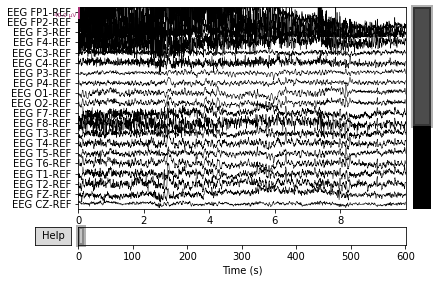

In [ ]:
plot_raw(path.join(dir_epilepsy,os.listdir(dir_epilepsy)[0]))

Extracting EDF parameters from /content/drive/MyDrive/dataset/edf/no_epilepsy/00002744_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


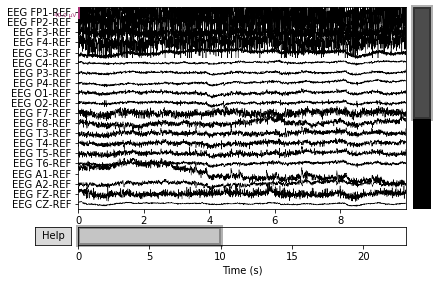

In [ ]:
plot_raw(path.join(dir_no_epilepsy,os.listdir(dir_no_epilepsy)[0]))

In [ ]:
#random dataset columns 
columns=['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF',
       'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF',
       'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF',
       'EEG T6-REF', 'EEG A1-REF', 'EEG A2-REF', 'EEG FZ-REF', 'EEG CZ-REF',
       'EEG PZ-REF', 'EEG ROC-REF', 'EEG LOC-REF', 'EEG EKG1-REF', 'EMG-REF',
       'EEG 26-REF', 'EEG 27-REF', 'EEG 28-REF', 'EEG 29-REF', 'EEG 30-REF',
       'EEG T1-REF', 'EEG T2-REF', 'PHOTIC-REF', 'IBI', 'BURSTS', 'SUPPR']

In [ ]:
num_samples = len(edf_names)
labels = tf.io.gfile.listdir(str(dir_data_set))
num_epil = len(tf.io.gfile.listdir(str(dir_data_set + "/" + labels[1])))
num_no_epil = len(tf.io.gfile.listdir(str(dir_data_set + "/" + labels[0])))
print(f"total of sample {num_samples}")
print(f"total of epilepsy {num_epil}")
print(f"total of no_epilepsy {num_no_epil}") 

total of sample 1656
total of epilepsy 1369
total of no_epilepsy 288


In [ ]:
edfu = {
    'epilepsy' : list_files_folder(path.join(base,'edf','epilepsy'),output=True),
    'no_epilepsy' : list_files_folder(path.join(base,'edf','no_epilepsy'),output=True)
}

1369 files found
'00007645_s006_t005.edf'
288 files found
'00006980_s002_t001.edf'


# ICA and PCA components

In [ ]:
df_ep = df_info(edfu['epilepsy'],edfu,'epilepsy',path.join(base,'edf'))
df_no_ep = df_info(edfu['no_epilepsy'],edfu,'no_epilepsy',path.join(base,'edf'))
df_no_ep_test = df_no_ep.assign(epileptic = 0)
df_ep_test = df_ep.assign(epileptic = 1)

df = pd.concat([df_no_ep_test,df_ep_test])

Extracting EDF parameters from /content/drive/MyDrive/datasets/edf/epilepsy/00000355_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/datasets/edf/epilepsy/00000355_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/datasets/edf/epilepsy/00000355_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/datasets/edf/epilepsy/00000355_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/datasets/edf/epilepsy/00000355_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/datasets/edf/epilepsy

In [ ]:
raw = mne.io.read_raw_edf(df.iloc[7]['link'],preload=True)

Extracting EDF parameters from /content/drive/MyDrive/datasets/edf/no_epilepsy/00006493_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 33749  =      0.000 ...   134.996 secs...


In [ ]:
remove_bad_channel(raw)

22  Channels deleted


In [ ]:
change_channel_name(raw,info=False)

<RawEDF | 00006493_s001_t000.edf, 19 x 33750 (135.0 s), ~4.9 MB, data loaded>

In [ ]:
montage = mne.channels.make_standard_montage('standard_1020')

In [ ]:
raw.set_montage(montage,on_missing='ignore')

<RawEDF | 00006493_s001_t000.edf, 19 x 33750 (135.0 s), ~4.9 MB, data loaded>

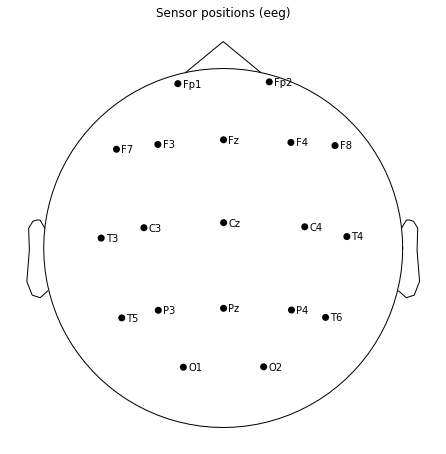

In [ ]:
sensor=raw.plot_sensors(show_names=True)

In [ ]:
event = mne.find_events(raw,stim_channel='Pz')

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


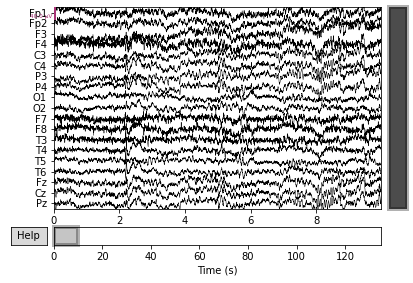

In [ ]:
#%matplotlib qt5
myplot=raw.plot()

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


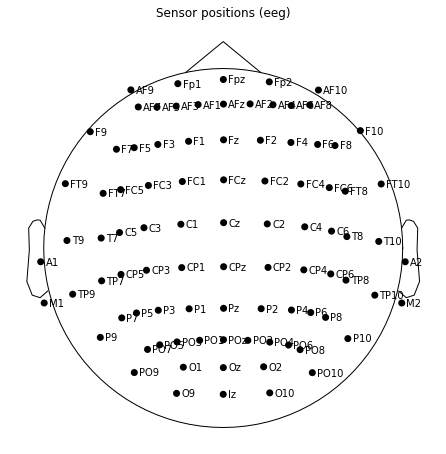

In [ ]:
montage = mne.channels.make_standard_montage('standard_1020')
p=montage.plot()

In [ ]:
raw.set_montage(montage,on_missing="ignore")
raw.set_montage(montage)

<RawEDF | 00006493_s001_t000.edf, 19 x 33750 (135.0 s), ~4.9 MB, data loaded>

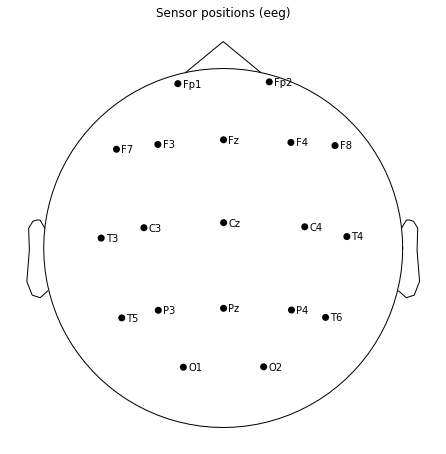

Effective window size : 8.192 (s)


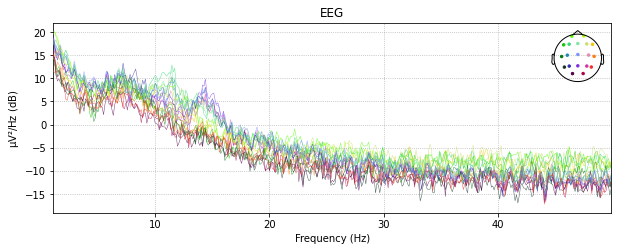

In [ ]:
myPltFsensor=raw.plot_sensors(show_names=True)
myPltF=raw.plot_psd(fmin=1, fmax=50,picks='eeg')

Extracting EDF parameters from /content/drive/MyDrive/datasets/edf/no_epilepsy/00006493_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 33749  =      0.000 ...   134.996 secs...
22  Channels deleted
before filtering


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


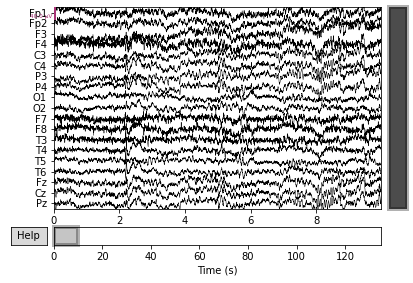

Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 825 samples (3.300 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 825 samples (3.300 sec)

after filtering


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


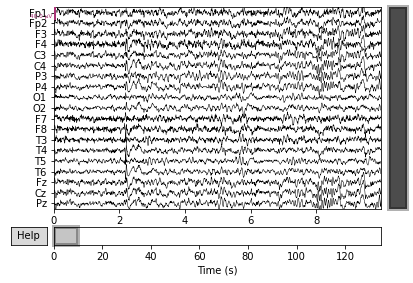

In [ ]:
filter_data,filter_param = filter_edf(df.iloc[7]['link'],2,50,plt=True)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
 
Fitting ICA took 4.3s.
ICA plot
Creating RawArray with float64 data, n_channels=19, n_times=33750
    Range : 0 ... 33749 =      0.000 ...   134.996 secs
Ready.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


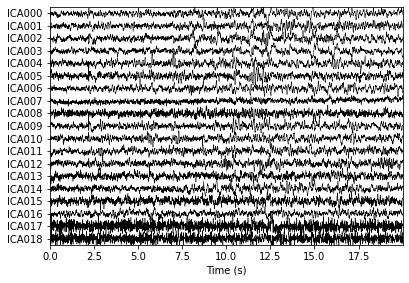

Plot ICA Overlay to verify artifact correction
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components


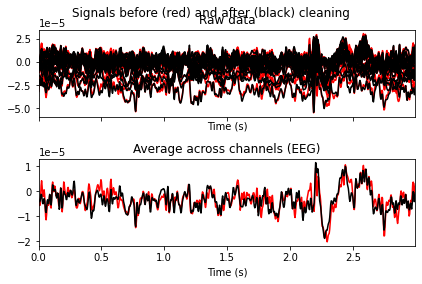

Plot ICA Source
Creating RawArray with float64 data, n_channels=19, n_times=33750
    Range : 0 ... 33749 =      0.000 ...   134.996 secs
Ready.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


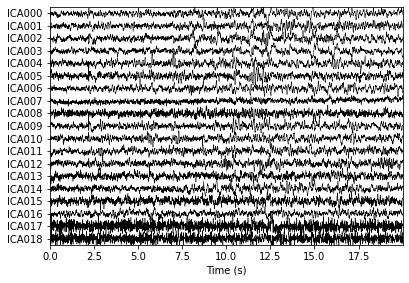

Plot ICA Properties
Creating RawArray with float64 data, n_channels=19, n_times=33500
    Range : 0 ... 33499 =      0.000 ...   133.996 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
67 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


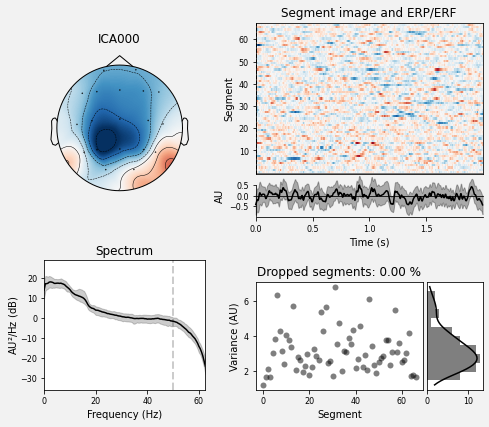

In [ ]:
ica = data_engineering_ica(filter_data,19,plt=True,nProperties=1)

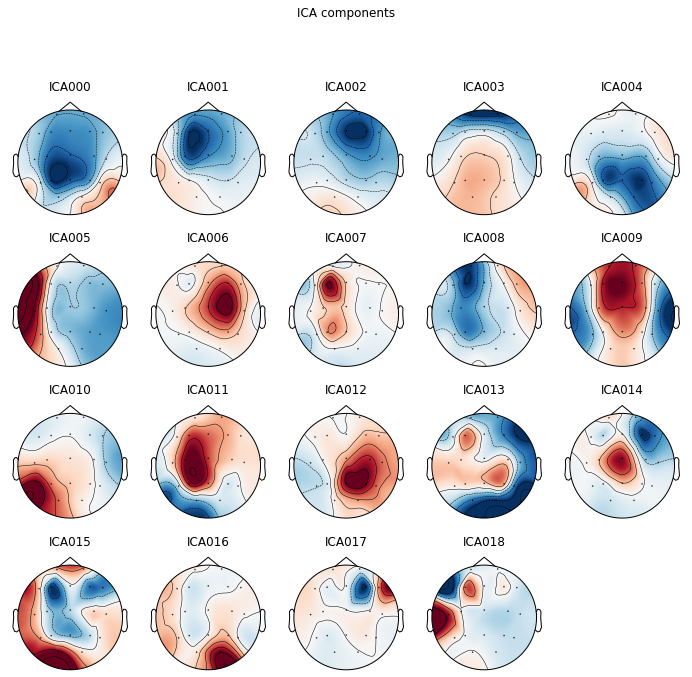

[<MNEFigure size 702x696.24 with 19 Axes>]

In [ ]:
ica.plot_components()

In [ ]:
filter_data.set_montage(montage,on_missing="ignore")
filter_data.set_montage(montage)

<RawEDF | 00006493_s001_t000.edf, 19 x 33750 (135.0 s), ~4.9 MB, data loaded>

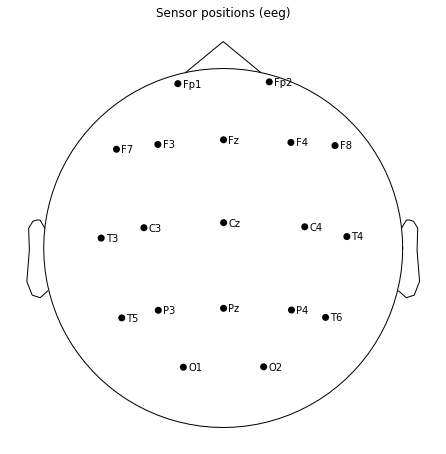

Effective window size : 8.192 (s)


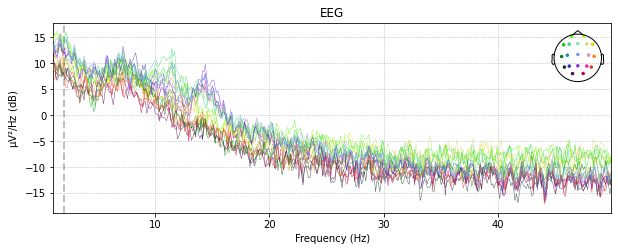

In [ ]:
myPltFsensor=filter_data.plot_sensors(show_names=True)
#plot spectral density
myPltF=filter_data.plot_psd(fmin=1, fmax=50,picks='eeg')

In [ ]:
ica_montage = ica.get_montage()

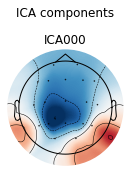

In [ ]:
plt_ica = ica.plot_components(picks=0,outlines='skirt')

In [ ]:
plt_ica.savefig(df.iloc[7]['name']+'_1'+'.png')

In [ ]:

image = Image.open(df.iloc[7]['name']+'_1'+'.png')

In [ ]:
box = (11, 43, 130, 165)
cropped_image = image.crop(box)
cropped_image.save(df.iloc[7]['name']+'_1'+'.png')

In [ ]:
os.listdir('ica')

['epilepsy', 'no_epilepsy']

In [ ]:
os.getcwd()

'/content/drive/My Drive/datasets'

In [ ]:
for i in os.listdir('ica'):
  for j in range(1,20):
    if j<10:
      os.mkdir(join(os.getcwd(),'ica',i,'0'+str(j)))
    else:
      os.mkdir(join(os.getcwd(),'ica',i,str(j)))

In [ ]:
root = os.getcwd()

In [ ]:
df.iloc[163][6]

1

In [ ]:
len(df)

227

Traitement of file  163
Extracting EDF parameters from /content/drive/MyDrive/datasets/edf/epilepsy/00000883_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308249  =      0.000 ...  1232.996 secs...
filtering load 
Extracting EDF parameters from /content/drive/MyDrive/datasets/edf/epilepsy/00000883_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 308249  =      0.000 ...  1232.996 secs...
18  Channels deleted
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 825 samples (

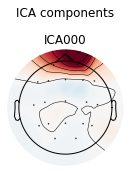

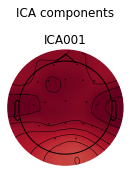

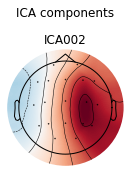

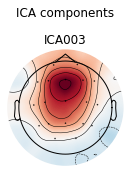

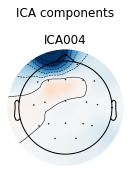

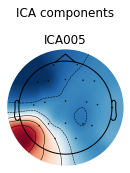

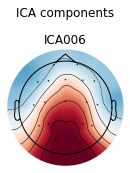

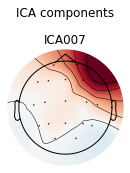

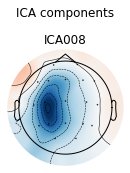

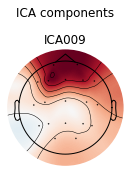

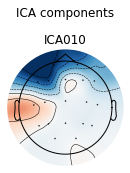

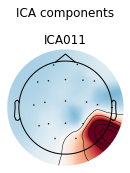

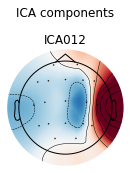

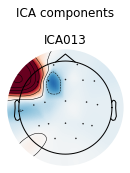

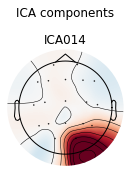

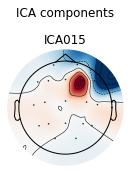

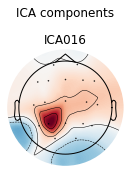

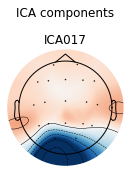

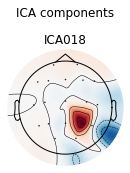

In [ ]:
#for i in range(101,len(df)):
#for i in range(163,164):
  print('Traitement of file ',str(i))
  raw = mne.io.read_raw_edf(df.iloc[i]['link'],preload=True)
  print('filtering load ')
  filter_data,filter_param = filter_edf(df.iloc[i]['link'],2,50)

  print('we make ica')
  ica = data_engineering_ica(filter_data,19)
  ica_montage = ica.get_montage()

  for j in range(0,19):

    plt_ica = ica.plot_components(picks=j,outlines='skirt')
    if df.iloc[j][6] == 1:
      print('im there')
      if j < 10:
        ica_file = join(root,'ica','epilepsy','0'+str(j))
        path = join(ica_file,df.iloc[i]['name']+'_ica_'+str(j)+'.png')
      if j >= 10:
        ica_file = join(root,'ica','epilepsy',str(j))
        path = join(ica_file,df.iloc[i]['name']+'_ica_'+str(j)+'.png')
      plt_ica.savefig(path)
      image = Image.open(path)
    if df.iloc[j][6] == 0:
      if j < 10:
        ica_file = join(root,'ica','no_epilepsy','0'+str(j))
        path = join(ica_file,df.iloc[i]['name']+'_ica_'+str(j)+'.png')
      if j >= 10:
        ica_file = join(root,'ica','no_epilepsy',str(j))
        path = join(ica_file,df.iloc[i]['name']+'_ica_'+str(j)+'.png')
      plt_ica.savefig(path)
      image = Image.open(path)
    
    box = (11, 43, 130, 165)
    cropped_image = image.crop(box)
    cropped_image.save(path)

    

#Transformation edf into csv

In [ ]:
#data = pd.DataFrame([],columns=["length","width","label","path","columns"])
for path in edf_names:
  label = path.split(os.path.sep)[-2]
  file_name = path.split(os.path.sep)[-1][:-4]
  new_path = extraction_path+os.path.sep+label+os.path.sep+file_name+".csv"
  
  if not os.path.isfile(new_path):
    raw = mne.io.read_raw_edf(path)
    df = pd.DataFrame(raw.to_data_frame(),columns=raw.ch_names)
    #data = data.append({"length":df.shape[0],"width":df.shape[1],"label":label,"path":new_path,"columns":list(df.columns)}, ignore_index=True)
    df.to_csv(new_path,index=False)

#data.to_csv(file_info_path,index=False)

In [ ]:
csv_names = tf.io.gfile.glob(str(extraction_path) + '/*/*.csv')

# Extraction des informations

In [ ]:
# get some informations about csv generated
if not os.path.isfile(file_info_path):
  data_shape = make_df_info(csv_names)
  data_shape.to_csv(file_info_path,index=False)
 

# Informations about csv files

In [ ]:
data_shape = pd.read_csv(file_info_path)

In [ ]:
data_shape.describe()

length        width
count  1.656000e+03  1656.000000
mean   2.492311e+05    33.140700
std    6.131227e+05     3.570119
min    1.250000e+03    27.000000
25%    7.680000e+04    30.000000
50%    1.538560e+05    34.000000
75%    3.035625e+05    36.000000
max    1.783760e+07    41.000000

In [ ]:
# separate csv files according a threshold for standardize the dataset
threshold2=40000

df3=data_shape[(data_shape["length"]>threshold2) & (data_shape["label"]=="epilepsy")]
df4=data_shape[(data_shape["length"]>threshold2) & (data_shape["label"]=="no_epilepsy")]

df5=data_shape[(data_shape["length"]<threshold2) & (data_shape["label"]=="epilepsy")]
df6=data_shape[(data_shape["length"]<threshold2) & (data_shape["label"]=="no_epilepsy")]


In [ ]:
print(f"{len(df3)} Fichiers de label epilepsy avec un nb d'enregistrement > {threshold2} ")
print(f"{len(df4)} Fichiers de label no_epilepsy avec un nb d'enregistrement > {threshold2} ")
print(f"{len(df5)} Fichiers de label epilepsy avec un nb d'enregistrement < {threshold2} ")
print(f"{len(df6)} Fichiers de label no_epilepsy avec un nb d'enregistrement < {threshold2} ")


1263 Fichiers de label epilepsy avec un nb d'enregistrement > 40000 
186 Fichiers de label no_epilepsy avec un nb d'enregistrement > 40000 
105 Fichiers de label epilepsy avec un nb d'enregistrement < 40000 
101 Fichiers de label no_epilepsy avec un nb d'enregistrement < 40000 


In [ ]:
# Differents type of column
data_shape["columns"] = data_shape["columns"].apply(replace_diff)
cols = data_shape["columns"].value_counts()
cols

['FP1','FP2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','T1','T2','FZ','CZ','PZ','EKG1','C3P','C4P','SP1','SP2','EMG','A1','A2','31','32','IBI','BURSTS','SUPPR']                                                                 405
['FP1','FP2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','A1','A2','FZ','CZ','PZ','ROC','LOC','EKG1','EMG','26','27','28','29','30','T1','T2','PHOTIC','IBI','BURSTS','SUPPR']                                                     305
['FP1','FP2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','A1','A2','FZ','CZ','PZ','ROC','LOC','EKG1','T1','T2','PHOTIC','IBI','BURSTS','SUPPR']                                                                                    169
['FP1','FP2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','T1','T2','FZ','CZ','PZ','EKG1','A1','A2','IBI','BURSTS','SUPPR']                                                                                 

# Fixing dimensions issue

In [ ]:
# extract columns that don't appear in the whole dataset
to_del = []
for i,col1 in enumerate(cols.index):
  col1 = str_index_to_list(col1)
  for j,col2 in enumerate(cols.index):
    if i!=j:
      col2 = str_index_to_list(col2)
      to_del = np.append(to_del,(list(set(col1)-set(col2)) + list(set(col2)-set(col1))))
to_del = np.unique(to_del)

In [ ]:
# get standardized column names for the dataset
cols = replace_diff(",".join(columns)).split(",")
columns = [col for col in cols if not col in to_del]
print(columns)
print(f"nb de colonnes {len(columns)} ")

['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']
nb de colonnes 19 


## Standardization

In [ ]:
merge_csv(df5,threshold2,division_path,columns)

In [ ]:
merge_csv(df6,threshold2,division_path,columns)

In [ ]:
divide_csv(df3,threshold2,division_path,columns) 

In [ ]:
divide_csv(df4,threshold2,division_path,columns)

#Preprocessing

In [ ]:
# Get all normalized files's name
divided_names = tf.io.gfile.glob(str(division_path) + '/*/*.csv')

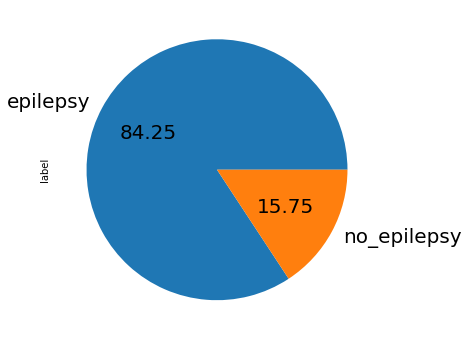

In [ ]:
names_label=pd.DataFrame(divided_names,columns=["path"])
names_label["label"]=names_label.path.map(lambda x : x.split("/")[-2])
names_label.label.value_counts().plot.pie(autopct="%.2f",fontsize=20, figsize=(6, 6),)

In [ ]:
# show a random sample standard dataframe
random_nb = np.random.randint(0,len(divided_names))
print(random_nb)
df=pd.read_csv(divided_names[random_nb])
df

2336


FP1        FP2        F3  ...        FZ         CZ         PZ
0      0.156088  -4.879309  3.513019  ... -1.980141   2.750080  10.532056
1      3.665607   0.308676 -2.743080  ...  0.766439   3.207843  12.668285
2      6.869950   2.902668  2.139729  ...  0.308676   0.156088  10.226881
3      5.191484  -1.827553  2.902668  ...  0.308676  -1.674965   6.412186
4      3.665607  -1.674965  1.987141  ...  0.919027  -1.674965   5.038896
...         ...        ...       ...  ...       ...        ...        ...
39995 -0.454263  -8.846591  1.224202  ... -6.100011   5.649248  17.398506
39996 -3.963782  -9.914705 -1.064614  ... -7.320713   8.548415  19.382147
39997 -5.337072 -10.067293 -1.827553  ... -6.252599  12.668285  24.417543
39998 -5.031896 -10.677644 -2.895668  ... -5.947423  14.957102  24.875307
39999 -8.236240  -7.778476 -6.100011  ... -6.252599  16.635567  25.943421

[40000 rows x 19 columns]

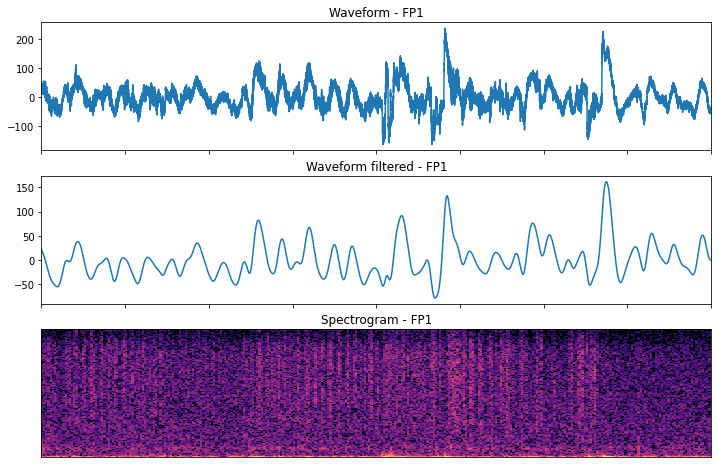

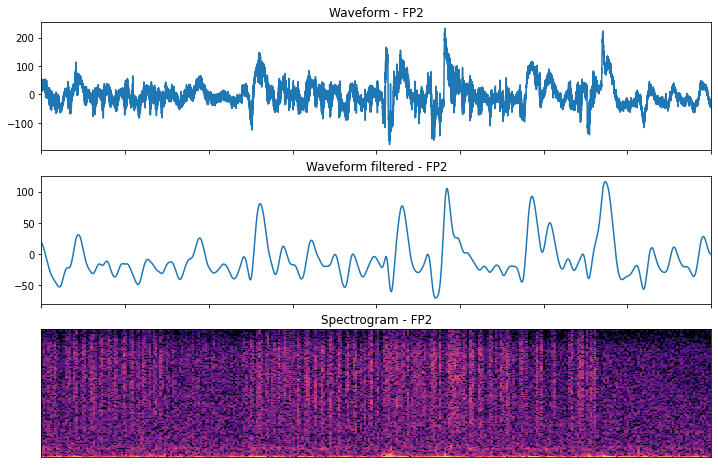

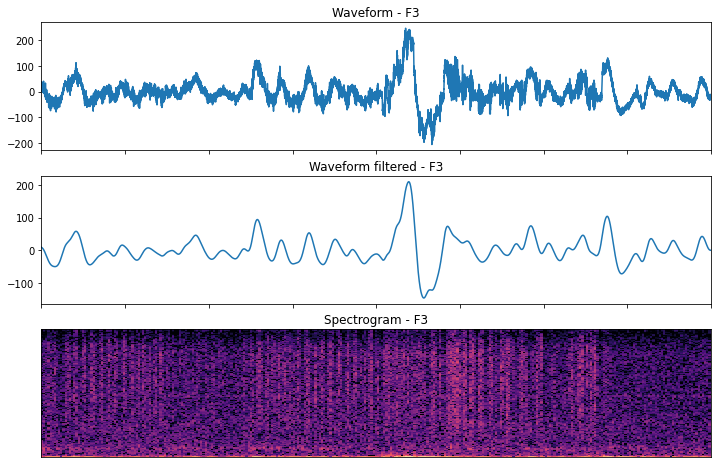

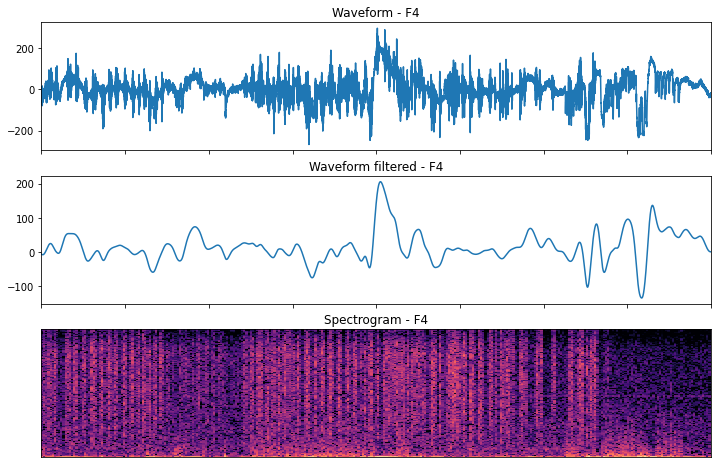

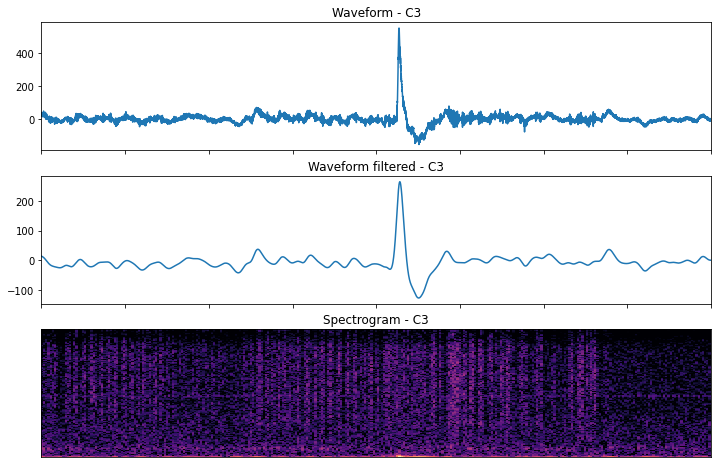

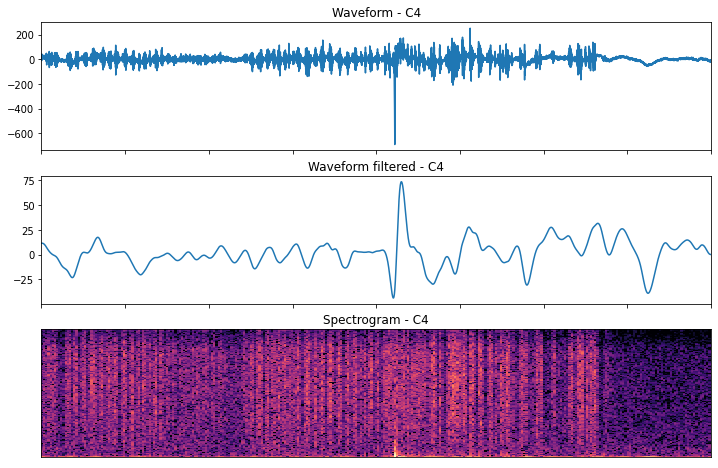

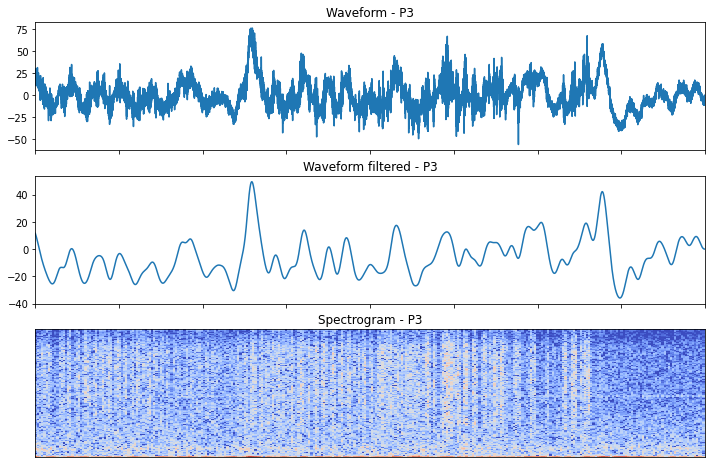

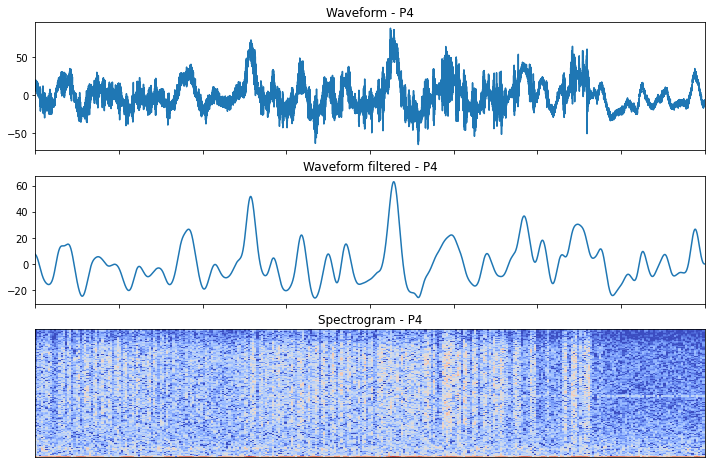

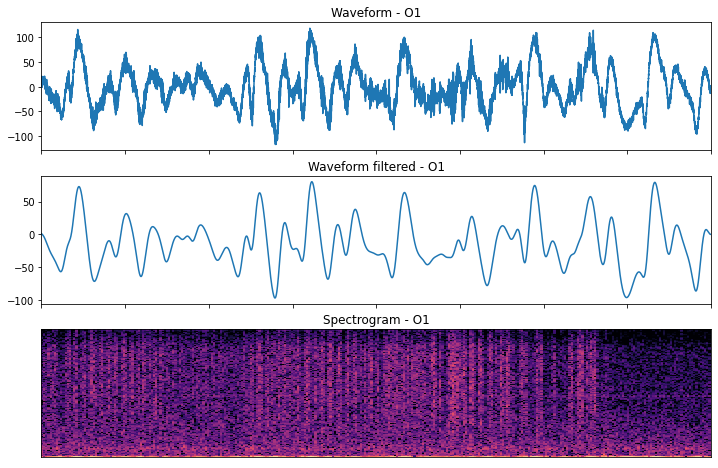

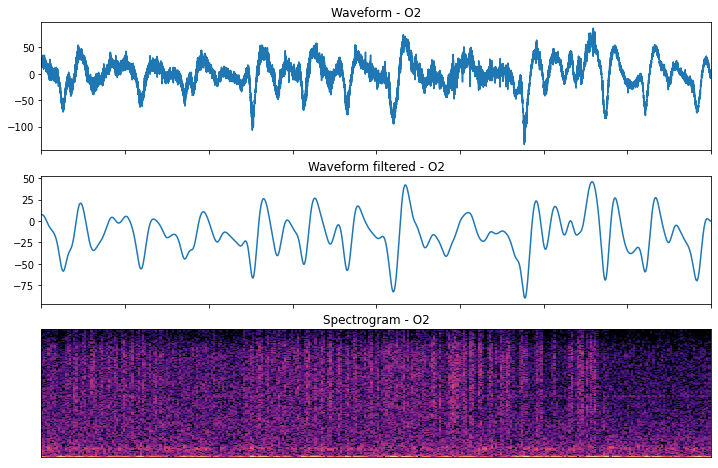

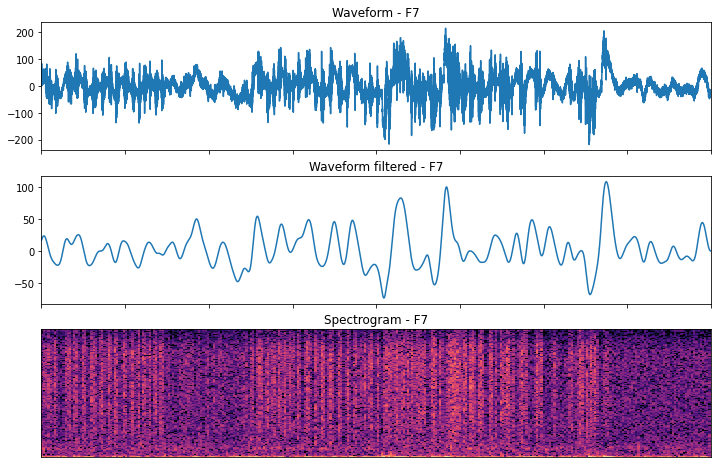

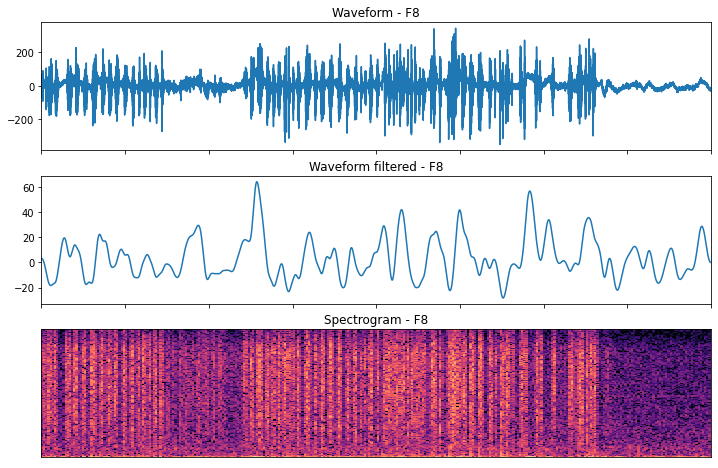

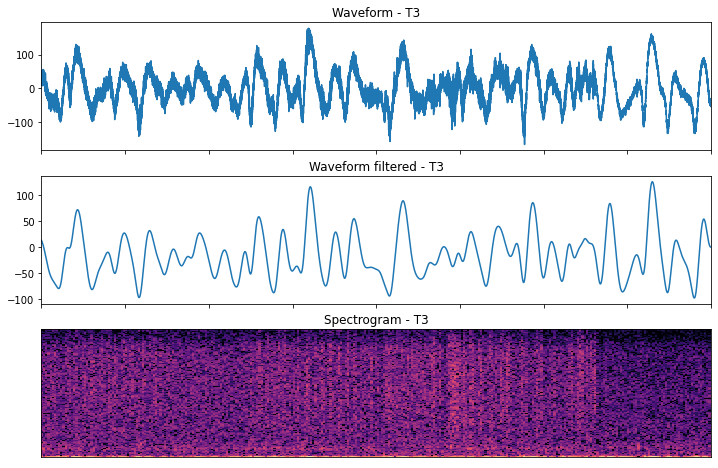

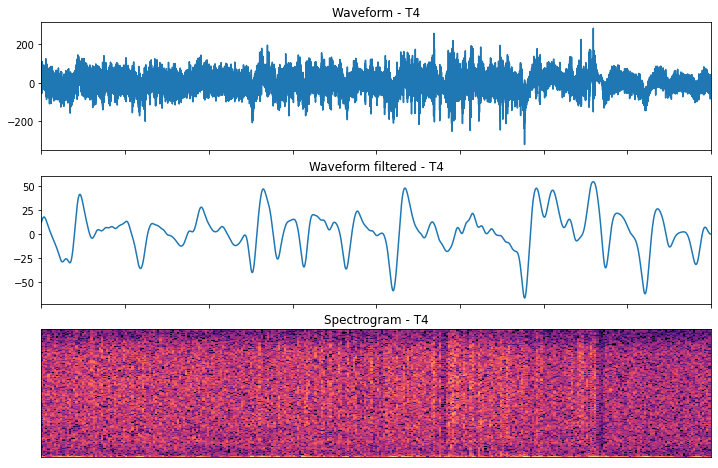

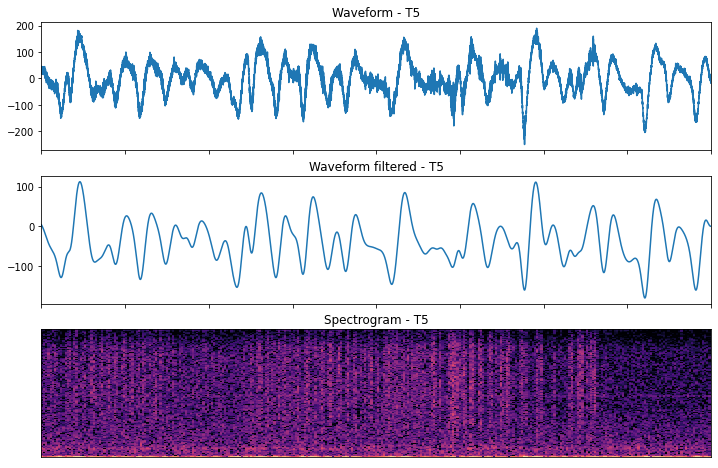

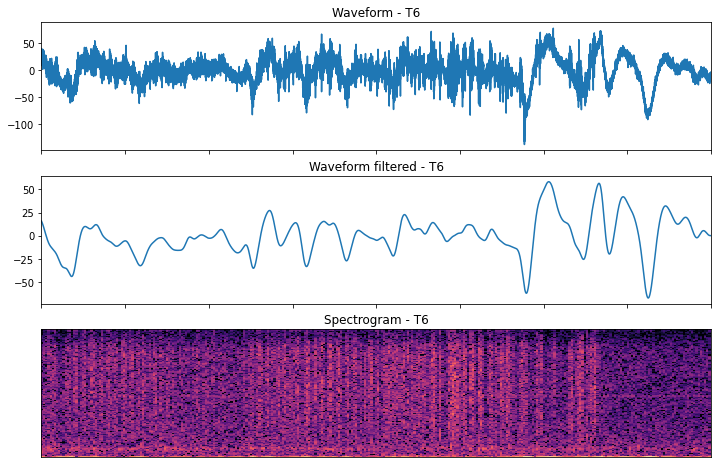

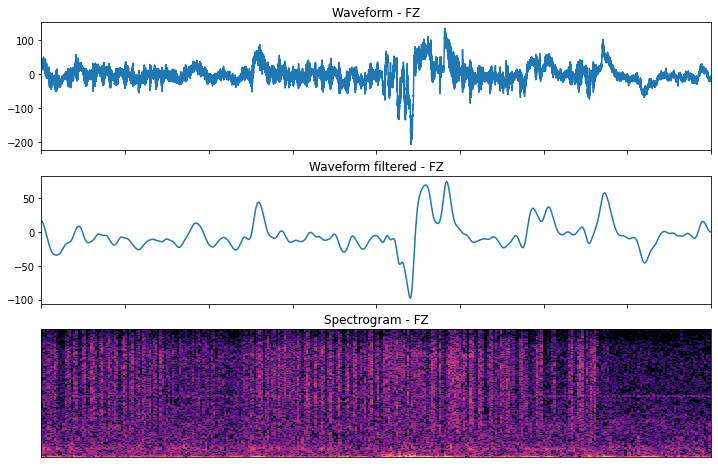

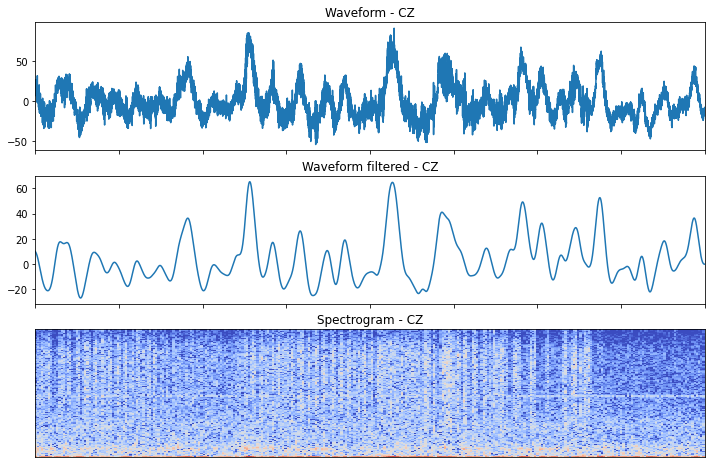

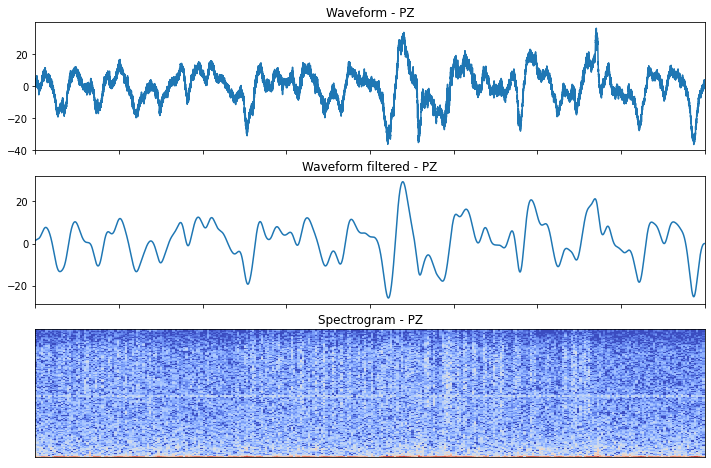

In [ ]:
#short fourrier tranformation on this sample
plot_signals_spects(df,True)

In [ ]:
# sample TensorSliceDataset
files_ds = tf.data.Dataset.from_tensor_slices(get_data_label2([divided_names[random_nb]]))
files_ds

0
[0]


<TensorSliceDataset shapes: ((311, 129, 19), ()), types: (tf.float64, tf.int64)>

In [ ]:
# rendering of tensor data
for spect,label in files_ds.take(1).as_numpy_iterator():
  print((spect),label)
  

[[[ 0.74646285  0.75874243  0.66221368 ...  0.74453618  0.66298639
    0.50590424]
  [ 0.69284578  0.70404789  0.62269193 ...  0.68989165  0.61256012
    0.47247449]
  [ 0.51387142  0.51154963  0.52018693 ...  0.4901065   0.47562418
    0.32220164]
  ...
  [ 0.07563033  0.06805568  0.09066224 ...  0.05163785 -0.0084613
   -0.03786444]
  [ 0.07563033  0.16438373  0.09066224 ...  0.07614776  0.04346832
   -0.08253362]
  [ 0.15837008  0.17908349  0.09066224 ...  0.1661463   0.12805718
   -0.06651362]]

 [[ 0.67668102  0.6941877   0.63501802 ...  0.66697495  0.4447244
    0.41498651]
  [ 0.61326899  0.62928893  0.5611336  ...  0.60596389  0.41578413
    0.40921408]
  [ 0.2231895   0.31995331  0.42237486 ...  0.27426894  0.35633688
    0.29203005]
  ...
  [ 0.15516598  0.06402891  0.09066224 ...  0.15702182  0.06287764
   -0.05798942]
  [ 0.19114487  0.18739175  0.16881093 ...  0.23666831  0.09806031
   -0.03882128]
  [ 0.23339183  0.26860215  0.2188805  ...  0.25518002  0.0805332
   -0.041

# Data Split

In [ ]:
# get same size between epilepsy and no_epilepsy
epilepsy_files = names_label[names_label["label"]=="epilepsy"].path.to_numpy()
no_epilepsy_files = names_label[names_label["label"]=="no_epilepsy"].path.to_numpy()
epilepsy_files = tf.random.shuffle(epilepsy_files,seed=40)[:len(no_epilepsy_files)].numpy()

In [ ]:
print(len(epilepsy_files))
print(len(no_epilepsy_files))

1625
1625


In [ ]:
# shuffle and split
data_set_files = tf.random.shuffle(np.append(epilepsy_files,no_epilepsy_files),seed=40)
train_files = [ tf.compat.as_str(el.numpy(), encoding='utf-8') for el in data_set_files[:2600]]
val_files = [ tf.compat.as_str(el.numpy(), encoding='utf-8') for el in data_set_files[2600: 2600 + 325]]
test_files = [ tf.compat.as_str(el.numpy(), encoding='utf-8') for el in data_set_files[-325:]]

In [ ]:
print('Train_set size', len(train_files))
print('Valid_set size', len(val_files))
print('Test_set size', len(test_files))

Train_set size 2600
Valid_set size 325
Test_set size 325


In [ ]:
# train set
spectrogram_ds = tf.data.Dataset.from_tensor_slices(get_data_label2(train_files))
train_ds = spectrogram_ds

In [ ]:
# validation set
val_ds = tf.data.Dataset.from_tensor_slices(get_data_label2(val_files))

In [ ]:
#test set
test_ds = tf.data.Dataset.from_tensor_slices(get_data_label2(test_files))

# Cache loading

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

In [ ]:
train_d = train_ds.batch(batch_size)
val_d = val_ds.batch(batch_size)

train_d = train_d.cache().prefetch(AUTOTUNE)
val_d = val_d.cache().prefetch(AUTOTUNE)

In [ ]:
test_d = test_ds.batch(batch_size)
test_d = test_d.cache().prefetch(AUTOTUNE)


# Normalization

In [ ]:
input_shape = spect.shape
print('Input shape:', input_shape)

Input shape: (311, 129, 19)


In [ ]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

# Model

In [ ]:
model = models.Sequential([
    layers.Input(shape=input_shape), 
    norm_layer,
    layers.Conv2D(8, 2, activation='relu'),
    layers.Conv2D(16, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 2, activation='relu'),
    layers.Conv2D(64, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 2, activation='relu'),
    layers.Conv2D(64, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 2, activation='relu'),
    layers.Conv2D(64, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(6528, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(2304, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1200, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(150, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1,activation='sigmoid'),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 311, 129, 19)      39        
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 310, 128, 8)       616       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 309, 127, 16)      528       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 154, 63, 16)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 153, 62, 32)       2080      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 152, 61, 64)       8256      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 76, 30, 64)       

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

In [ ]:
timestamp =  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir+timestamp, histogram_freq=1)
early_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",verbose=1, patience=6,restore_best_weights=True)


In [ ]:
class AccuracyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get("accuracy")==0.93:
      self.model.stop_training = True

In [ ]:
EPOCHS = 60
history = model.fit(
    train_d, 
    validation_data=val_d,  
    epochs=EPOCHS,
    callbacks=[early_callback,AccuracyCallback()]
),

Epoch 1/60
 6/63 [=>............................] - ETA: 14s - loss: 0.7581 - accuracy: 0.4188WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.2863s). Check your callbacks.


63/63 [==============================] - 33s 301ms/step - loss: 0.7135 - accuracy: 0.4871 - val_loss: 0.7057 - val_accuracy: 0.4338
Epoch 2/60
63/63 [==============================] - 26s 300ms/step - loss: 0.6851 - accuracy: 0.5453 - val_loss: 0.6241 - val_accuracy: 0.5723
Epoch 3/60
63/63 [==============================] - 25s 297ms/step - loss: 0.6451 - accuracy: 0.6075 - val_loss: 0.7170 - val_accuracy: 0.6462
Epoch 4/60
63/63 [==============================] - 26s 303ms/step - loss: 0.6149 - accuracy: 0.6948 - val_loss: 0.6086 - val_accuracy: 0.6708
Epoch 5/60
63/63 [==============================] - 26s 300ms/step - loss: 0.5130 - accuracy: 0.7581 - val_loss: 0.3875 - val_accuracy: 0.8400
Epoch 6/60
63/63 [==============================] - 26s 298ms/step - loss: 0.4324 - accuracy: 0.8207 - val_loss: 0.3822 - val_accuracy: 0.8523
Epoch 7/60
63/63 [==============================] - 25s 296ms/step - loss: 0.3980 - accuracy: 0.8350 - val_loss: 0.3600 - val_accuracy: 0.8492
Epoch 8/60

In [ ]:
model.save(projet_path+'my_model.h5')

#Results

In [ ]:
%tensorboard --logdir {log_dir}

In [ ]:
history[0].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


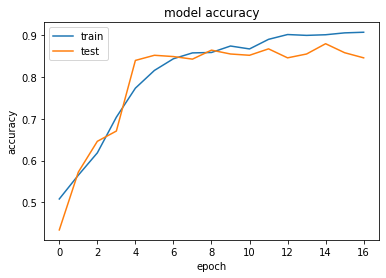

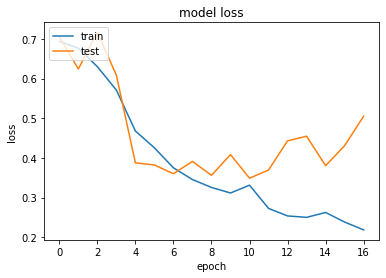

In [ ]:
plot_history(history)

In [ ]:
model = models.load_model(projet_path+'my_model.h5')

In [ ]:
loss,acc=model.evaluate(test_d)

In [ ]:
predictions=modele.predict_classes(test_d)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
labels = []
for _ ,label in test_ds.as_numpy_iterator():
  labels.append(label)
  
c_matrics = tf.math.confusion_matrix(
    labels, predictions, num_classes=2,
)

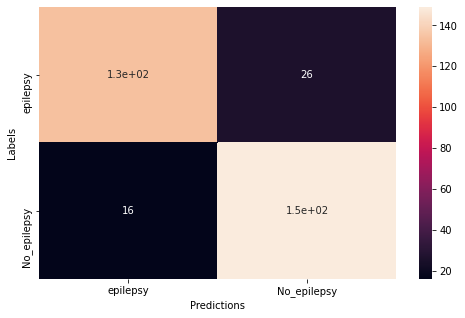

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(c_matrics,annot=True,xticklabels=["epilepsy","No_epilepsy"],yticklabels=["epilepsy","No_epilepsy"])
plt.ylabel("Labels")
plt.xlabel("Predictions")
plt.show()

In [ ]:
print(classification_report(labels, predictions,digits=7,target_names=["epilepsy","No_epilepsy"]))

              precision    recall  f1-score   support

    epilepsy  0.8933333 0.8375000 0.8645161       160
 No_epilepsy  0.8514286 0.9030303 0.8764706       165

    accuracy                      0.8707692       325
   macro avg  0.8723810 0.8702652 0.8704934       325
weighted avg  0.8720586 0.8707692 0.8705853       325



#Deployment test

## It take as entry edf files and the output is the prediction

In [ ]:
csv_test_files = preprocessing_edf(projet_path,edf_names[:1])

test = tf.data.Dataset.from_tensor_slices(get_data_label2(csv_test_files))

prediction(test)

Extracting EDF parameters from /content/drive/MyDrive/dataset/edfu/no_epilepsy/00007026_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
0
reste (40000, 19)
/content/drive/MyDrive/dataset/prod/bf5185d6-b752-11eb-b6b2-0242ac1c0002
0
1
2
3
4
5
6
7
[0 0 0 0 0 0 0 0]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predictions : [[1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]]
score : {'epilepsy': 2, 'no_epilepsy': 6}


'no_epilepsy'

#Modele tunning

In [ ]:
from kerastuner.tuners import RandomSearch

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    #batch_size = [32, 64][random.randint(0, 1)]
    model.add(keras.Input(shape=(311, 129, 19)))
    model.add(norm_layer)
    
    for i in range(hp.Int('num_layers_conv', 2, 6)):
      model.add(layers.Conv2D(hp.Int('conv2D_1_' + str(i),32,256,32), 2, activation='relu'))
      model.add(layers.Conv2D(hp.Int('conv2D_2_' + str(i),32,256,32), 2, activation='relu'))
      if  i%2==0:
        model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())
    for i in range(hp.Int('num_layers_dense', 1, 4)):  
      model.add(layers.Dense(units=hp.Int('units_' + str(i),min_value=1024,max_value=128,step=-256), activation='relu'))
      model.add(layers.Dropout(hp.Choice('dropout_' + str(i), [0.2,0.5]))),
      
    model.add(layers.Dense(1, activation='sigmoid'))# 

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss=keras.losses.BinaryCrossentropy(True),
        metrics=['accuracy'])#,keras.metrics.Precision()
    return model



In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory=projet_path+"tuner",
    project_name='optimizer')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/dataset/tuner/optimizer/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/dataset/tuner/optimizer/tuner0.json


In [ ]:
tuner.search(train_d,
             epochs=20,
             validation_data=val_d,callbacks=[early_callback])

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)

In [ ]:
model.summary()